# Optimisation linéaire
## Contraintes discontinues et Piecewize avec différents solveurs.

## Introduction:
Dans ce document, je traite 3 types de coûts dans le cadre d'une optimisation linéaire
de type produits mix.
- Les coûts additionnels en fonction du nombre d'objets produits
- Les coûts discontinus en fonction du nombre d'objets produits ( Discontinuous piecewize)
- Les coûts proportionnels au nombre d'objets produits appelés les fonctions piecewize.
Je résouds avec le solveur Python Cplex.

Principal lien utilisé :
https://ibmdecisionoptimization.github.io/tutorials/html/Beyond_Linear_Programming.html

# Sommaire :

- Problème pratique de coûts additionnels.
- Problème pratique de coûts piecewize discontinus.
- Dessiner les coûts discontinus avec Matplot.
- Résoudre le Problème pratique discontinu Avec Cplex.
- L'exemple de discount pour les cars avec Cplex
- Problème pratique de coûts en fonctions piecewize .
- Dessiner les contraintes fonctions Piecewize avec Matplot
- Résoudre le Problème pratique de fonctions Piecewize Avec Cplex
- Résoudre le Problème pratique de fonctions  Piecewize Avec Pulp
- Résoudre le Problème pratique de fonctions  Piecewize Avec Gekko
- Résoudre le Problème pratique de fonctions  Piecewize Avec Excel
- Résoudre le Problème pratique de fonctions  Piecewize Avec Cvxopt


!! Création en cours Sujet à de lourdes modifications !!

Etude fournie pas Estelle Derrien - Github estelle15000



# Problème pratique de coûts additionels

Mon usine produit 2 objets A et B vendus 30  euros.
Le temps machine disponible est de 1000 heures .

- Si la production de A > 0, alors le côut de maintenance est de 20
- Si la production de A > 200, alors le côut de maintenance est de 30 euros supplémentaires 
- Si la production de A > 500, alors le côut de maintenance est de 30 euros supplémentaires

Il n'y a pas de cout de maintenance pour l'objet b.

Rappel : La fonction objectif tient compte des coûts lors de l'optimisation, de ce fait, elle pourra choisir plus d'objets B si elle voit que l'objet A implique plus de coûts.

Comme les coûts s'additionnent, on peut utiliser les variables binaires :


In [218]:
import cplex
import docplex.mp
from docplex.mp.model import Model

# On crée notre modèle
model = Model(name='LP_example')

# On crée nos variables de décision
a = model.integer_var(name='a')
b = model.integer_var(name='b')
z = model.binary_var(name='z')
k = model.binary_var(name='k')
t = model.binary_var(name='t')

model.maximize(30 * a + 30 * b - z * 20 - k * 100 - t * 200)

# On crée les contraintes
model.add_constraint(a + b <= 1000)
model.add_constraint(a >= 200)
model.add_constraint(b >= 200)

# On crée les contraintes binaires qui vont activer ou pas les couts dans la fonction objectif
model.add_constraint(model.if_then(a >= 0, z == 1))
model.add_constraint(model.if_then(a >= 300, k == 1))
model.add_constraint(model.if_then(a >= 500, t == 1))

model.solve()

for v in model.iter_integer_vars():
    print(v," = ",v.solution_value) 

for v in model.iter_binary_vars():
    print(v," = ",v.solution_value) 

print(model.solution)

a  =  200.0
b  =  800.0
z  =  1.0
k  =  0
t  =  0
_bool#1  =  1.0
_bool#2  =  0
_bool#3  =  0
solution for: LP_example
objective: 29980
status: OPTIMAL_SOLUTION(2)
a=200
b=800
z=1



# Problème pratique de coûts discontinus

Mon usine produit 2 objets A et B vendus 30 et 25 euros.
Le temps machine disponible est de 1000 heures .

- Si la production de A > 0, alors le côut de maintenance est de 20 en tout
- Si la production de A > 200, alors le côut de maintenance est de 30 euros en tout
- Si la production de A > 500, alors le côut de maintenance est de 50 euros en tout

# Dessiner les contraintes conditionnelles discontinues avec Matplot

Ibm Cplex appelle ça les contraintes de coût discontinues .

Ils ont un exemple ici :
https://www.ibm.com/docs/en/icos/20.1.0?topic=expressions-discontinuous-piecewise-linear-functions

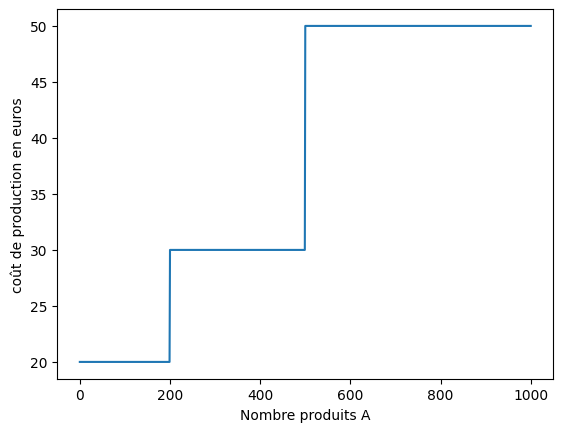

In [219]:
# On visualise nos contraintes de type conditionnelles  avec les valeurs réelles de notre problème
# Edit, peut-on qualifier ça de piecewize, selon la doc Cplex, c'est du piecewize discontinuous... .
import matplotlib.pyplot as plt
plt.plot([0, 199, 200, 499,500,1000], [20,20,30, 30, 50 ,50])
plt.xlabel('Nombre produits A')
plt.ylabel('coût de production en euros')
plt.show()

# Résoudre le Problème pratique discontinu Avec Cplex

Code à contrôler..

In [220]:
import cplex
import docplex.mp
from docplex.mp.model import Model

# On crée notre modèle
model = Model(name='LP_example')

# On crée nos variables de décision
a = model.integer_var(name='a')
b = model.integer_var(name='b')

# On crée les contraintes
model.add_constraint(a + b <= 1000)
model.add_constraint(a >= 200)
model.add_constraint(b >= 200)

# On définit la fonction piecewize de type discontinue
f = model.piecewise(0, [(0, 20), (200, 30), (500, 50)],1)

# On maximise moins les coûts provenant de la fonction piecewize f(x)
model.maximize(20 * a - f(a) + 30 * b)

model.solve()

for v in model.iter_integer_vars():
    print(v," = ",v.solution_value) 

for v in model.iter_binary_vars():
    print(v," = ",v.solution_value) 

print(model.solution)

a  =  200.0
b  =  800.0
solution for: LP_example
objective: 27970
status: OPTIMAL_SOLUTION(2)
a=200
b=800



# Exemple du Bus

Dans cet exemple, Il y a une réduction du prix en pourcentage lorsque le nombre de bus utilisés dépasse 4.

https://github.com/AlexFleischerParis/zoodocplex/blob/master/zoopiecewise.py

In [221]:
'''
abordons maintenant une nouvelle information : pour une taille de bus donnée
si nous en prenons plus de 4, nous obtenons une réduction de 20%
Cela déplace le coût de notre fonction de linéaire à linéaire par morceaux.

'''

from docplex.mp.model import Model

mdl = Model(name='buses')
nbbus40 = mdl.integer_var(name='nbBus40')
nbbus30 = mdl.integer_var(name='nbBus30')
mdl.add_constraint(nbbus40*40 + nbbus30*30 >= 300, 'kids')

#après 4 bus, les bus supplémentaires d'une taille donnée sont moins chers
f=mdl.piecewise(0, [(0, 0),(4,4)], 0.8)

mdl.minimize(f(nbbus40)*500 + f(nbbus30)*400)

mdl.solve()

for v in mdl.iter_integer_vars():
    print(v," = ",v.solution_value)

'''
Solution
nbBus40  =  0
nbBus30  =  10.0
'''

nbBus40  =  0
nbBus30  =  10.0


'\nwhich gives\nnbBus40  =  0\nnbBus30  =  10.0\n'

# Dessiner les fonctions Piecewize avec Matplot

Hypothèse : La différence, avec les contraintes piecewize, c'est que ce sont des fonctions  linéaires qui décrivent l'évolution des coûts et pas des valeurs-seuils fixes.
On pourrait imaginer de les affecter dans l'optimisation, en fonction de leurs valeurs "breaking points". Reste à voir comment faire dans les solveurs , et si la logique reste valable en comparant avec ce que font les autres.

Hypothèse2 : Le but est de switcher en fonction des breaking point, afin que l'optimisation globale reste linéaire.
On décompose une fonction convexe en plusieurs parties linéaires selon une méthode précise, voir la documentation.

Hypothèse3 : Vu que Gekko est non linéaire, on pourrait même avoir des fonctions non linéaire dans ce système mais ce n'est pas le but( Voir l'optimisation " Pricing de 1 produit " ).







Voici un exemple, elles peuvent aussi être discontinues comme sur le dessin (Doc Cplex) :

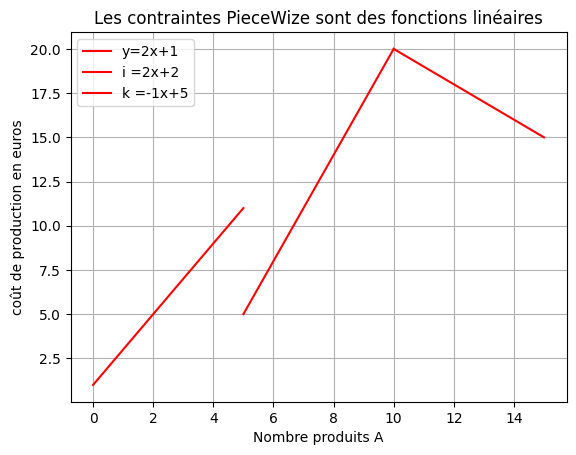

In [222]:
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0,5,100)
m = np.linspace(5,10,100)
t = np.linspace(10,15,100)
y = 2*x+1
i = 3*x+5
k = -1*x+20
plt.plot(x, y, '-r', label='y=2x+1')
plt.plot(m, i, '-r', label='i =2x+2')
plt.plot(t, k, '-r', label='k =-1x+5')
plt.title('Les contraintes PieceWize sont des fonctions linéaires')
plt.xlabel('Nombre produits A')
plt.ylabel('coût de production en euros')
plt.legend(loc='upper left')
plt.grid()
plt.show()



# Problème pratique avec Cplex

Considérons un problème de transport dans lequel le coût de transport entre une origine,i, et une destination, j, dépend de la taille de l'expédition, ship ij.


- Les 1000 premiers articles ont un coût d'expédition de 0,40 $ par article
- Pour les 2000 articles suivants (c'est-à-dire les articles 1001-3000), le coût est de 0,20 $ par article
- À partir de l'article 3001, le coût diminue à 0,10 $ par article.

Le coût de chaque tranche de quantité reste inchangé (c'est-à-dire que le coût unitaire ne change que pour les unités supplémentaires et reste inchangé pour la tranche de quantité précédente).

Dans chaque tranche, il existe une relation linéaire entre le coût et la quantité, mais à chaque point de rupture, le taux de variation linéaire change.

Lien: https://ibmdecisionoptimization.github.io/tutorials/html/Beyond_Linear_Programming.html


On essaye de coder à avec les breackpoints, là ,On fixe le prix d'un article à 20 euros pour l'exemple.


!!!!!!!!!!!!!CREATION EN COURS CODE EN TRAIN DETRE FAIT A PRIORI CEST BON MAIS A CONTROLER A FOND!!!!!!!!!!!!!

a  =  1000.0
_pwl1  =  400.0
solution for: LP_example
objective: 19600
status: OPTIMAL_SOLUTION(2)
a=1000.000



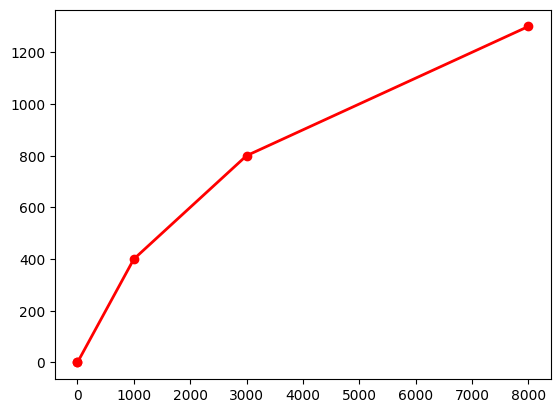

In [223]:
import cplex
import docplex.mp
from docplex.mp.model import Model

# On crée notre modèle
model = Model(name='LP_example')

# On crée les fonctions piecewize avec leur breakpoints
pwf2 = model.piecewise(preslope=0, breaksxy=[(0, 0), (1000, 400), (3000, 800)], postslope=0.1)

# On crée nos variables de décision
a = model.continuous_var(name='a')

# On crée cette pour contrôler si les couts piecewize fonctionnent quand on change la valeur
model.add_constraint(a  <= 1000)

# On maximise notre profit, moins les couts de type piecewize
model.maximize(a * 20 - pwf2(a))

model.solve()

for v in model.iter_integer_vars():
    print(v," = ",v.solution_value) 

for v in model.iter_continuous_vars():
    print(v," = ",v.solution_value) 

for v in model.iter_binary_vars():
    print(v," = ",v.solution_value) 

print(model.solution)

# On dessine les fonctions de couts piecewize
pwf2.plot(lx=-1, rx=8000, k=1, color='r', marker='o', linewidth=2)

Liens:
https://stackoverflow.com/questions/61947896/using-the-piecewise-function-of-the-ibm-cplex-python-api-but-the-problem-cannot